# Hilti explorer

> Ayush Baid, Frank Dellaert

A notebook to investigate the hilti dataset

In [97]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import dask
import plotly.express as px
import gtsam
from gtsam import Cal3Bundler, EssentialMatrix, Point3, Pose3, Rot3, Unit3
from gtbook.drone import axes
import hydra
from dask.distributed import Client, LocalCluster
from hydra.utils import instantiate
from omegaconf import OmegaConf


import gtsfm.utils.io as io_utils
from gtsfm.loader.hilti_loader import HiltiLoader
from gtsfm.common.gtsfm_data import GtsfmData
from gtsfm.common.image import Image
from gtsfm.common.keypoints import Keypoints
from gtsfm.frontend.detector_descriptor.sift import SIFTDetectorDescriptor
from gtsfm.frontend.matcher.twoway_matcher import TwoWayMatcher
from gtsfm.utils import viz
from gtsfm.frontend.verifier.ransac import Ransac
from gtsfm.scene_optimizer import SceneOptimizer
from gtsfm.retriever.sequential_hilti_retriever import SequentialHiltiRetriever
from gtsfm.two_view_estimator import TwoViewEstimator
import gtsfm.utils.geometry_comparisons as comp_utils

In [6]:
# cwd = Path.cwd()
folder_path = Path("/media/ayush/cross_os1/dataset/hilti")

In [52]:
# Load Images
indices = range(300, 300+20)
loader = HiltiLoader(base_folder=str(folder_path), max_frame_lookahead=1)
images = [loader.get_image(i) for i in indices]

[2022-05-08 19:30:01,377 INFO hilti_loader.py line 89 466751] Number of keys in g2o file: 1255


INFO - 2022-05-08 19:30:01,377 - hilti_loader - Number of keys in g2o file: 1255


[2022-05-08 19:30:01,384 INFO hilti_loader.py line 78 466751] Loading 591 timestamps


INFO - 2022-05-08 19:30:01,384 - hilti_loader - Loading 591 timestamps


[2022-05-08 19:30:01,387 INFO hilti_loader.py line 79 466751] Lidar camera available for 591 timestamps


INFO - 2022-05-08 19:30:01,387 - hilti_loader - Lidar camera available for 591 timestamps


[2022-05-08 19:30:01,389 DEBUG hilti_loader.py line 180 466751] Mapping 300 index to rig 60, camera 0


DEBUG - 2022-05-08 19:30:01,389 - hilti_loader - Mapping 300 index to rig 60, camera 0


[2022-05-08 19:30:01,395 DEBUG hilti_loader.py line 180 466751] Mapping 301 index to rig 60, camera 1


DEBUG - 2022-05-08 19:30:01,395 - hilti_loader - Mapping 301 index to rig 60, camera 1


[2022-05-08 19:30:01,402 DEBUG hilti_loader.py line 180 466751] Mapping 302 index to rig 60, camera 2


DEBUG - 2022-05-08 19:30:01,402 - hilti_loader - Mapping 302 index to rig 60, camera 2


[2022-05-08 19:30:01,416 DEBUG hilti_loader.py line 180 466751] Mapping 303 index to rig 60, camera 3


DEBUG - 2022-05-08 19:30:01,416 - hilti_loader - Mapping 303 index to rig 60, camera 3


[2022-05-08 19:30:01,426 DEBUG hilti_loader.py line 180 466751] Mapping 304 index to rig 60, camera 4


DEBUG - 2022-05-08 19:30:01,426 - hilti_loader - Mapping 304 index to rig 60, camera 4


[2022-05-08 19:30:01,443 DEBUG hilti_loader.py line 180 466751] Mapping 305 index to rig 61, camera 0


DEBUG - 2022-05-08 19:30:01,443 - hilti_loader - Mapping 305 index to rig 61, camera 0


[2022-05-08 19:30:01,453 DEBUG hilti_loader.py line 180 466751] Mapping 306 index to rig 61, camera 1


DEBUG - 2022-05-08 19:30:01,453 - hilti_loader - Mapping 306 index to rig 61, camera 1


[2022-05-08 19:30:01,464 DEBUG hilti_loader.py line 180 466751] Mapping 307 index to rig 61, camera 2


DEBUG - 2022-05-08 19:30:01,464 - hilti_loader - Mapping 307 index to rig 61, camera 2


[2022-05-08 19:30:01,475 DEBUG hilti_loader.py line 180 466751] Mapping 308 index to rig 61, camera 3


DEBUG - 2022-05-08 19:30:01,475 - hilti_loader - Mapping 308 index to rig 61, camera 3


[2022-05-08 19:30:01,490 DEBUG hilti_loader.py line 180 466751] Mapping 309 index to rig 61, camera 4


DEBUG - 2022-05-08 19:30:01,490 - hilti_loader - Mapping 309 index to rig 61, camera 4


[2022-05-08 19:30:01,504 DEBUG hilti_loader.py line 180 466751] Mapping 310 index to rig 62, camera 0


DEBUG - 2022-05-08 19:30:01,504 - hilti_loader - Mapping 310 index to rig 62, camera 0


[2022-05-08 19:30:01,515 DEBUG hilti_loader.py line 180 466751] Mapping 311 index to rig 62, camera 1


DEBUG - 2022-05-08 19:30:01,515 - hilti_loader - Mapping 311 index to rig 62, camera 1


[2022-05-08 19:30:01,526 DEBUG hilti_loader.py line 180 466751] Mapping 312 index to rig 62, camera 2


DEBUG - 2022-05-08 19:30:01,526 - hilti_loader - Mapping 312 index to rig 62, camera 2


[2022-05-08 19:30:01,537 DEBUG hilti_loader.py line 180 466751] Mapping 313 index to rig 62, camera 3


DEBUG - 2022-05-08 19:30:01,537 - hilti_loader - Mapping 313 index to rig 62, camera 3


[2022-05-08 19:30:01,548 DEBUG hilti_loader.py line 180 466751] Mapping 314 index to rig 62, camera 4


DEBUG - 2022-05-08 19:30:01,548 - hilti_loader - Mapping 314 index to rig 62, camera 4


[2022-05-08 19:30:01,560 DEBUG hilti_loader.py line 180 466751] Mapping 315 index to rig 63, camera 0


DEBUG - 2022-05-08 19:30:01,560 - hilti_loader - Mapping 315 index to rig 63, camera 0


[2022-05-08 19:30:01,575 DEBUG hilti_loader.py line 180 466751] Mapping 316 index to rig 63, camera 1


DEBUG - 2022-05-08 19:30:01,575 - hilti_loader - Mapping 316 index to rig 63, camera 1


[2022-05-08 19:30:01,584 DEBUG hilti_loader.py line 180 466751] Mapping 317 index to rig 63, camera 2


DEBUG - 2022-05-08 19:30:01,584 - hilti_loader - Mapping 317 index to rig 63, camera 2


[2022-05-08 19:30:01,592 DEBUG hilti_loader.py line 180 466751] Mapping 318 index to rig 63, camera 3


DEBUG - 2022-05-08 19:30:01,592 - hilti_loader - Mapping 318 index to rig 63, camera 3


[2022-05-08 19:30:01,600 DEBUG hilti_loader.py line 180 466751] Mapping 319 index to rig 63, camera 4


DEBUG - 2022-05-08 19:30:01,600 - hilti_loader - Mapping 319 index to rig 63, camera 4


In [10]:
translations = np.array([loader.get_absolute_pose_prior(i).value.translation() for i in range(len(loader))])
print(translations.shape)

(2955, 3)


In [18]:
print(translations.shape)

(591, 3)


In [98]:
wTimu0 = Pose3(Rot3(Point3(1, 0, 0), Point3(0, -1, 0), Point3(0, 0, -1)), Point3(0, 0, 0))

In [107]:
rig_indices = range(0, 250)
wTimu = {i: (wTimu0 * loader._w_T_imu[i]) for i in rig_indices}
translations = np.array([t.translation() for t in wTimu.values()])

# print(poses)
fig = px.scatter_3d(x=translations[:, 0], y=translations[:, 1], z=translations[:, 2])
for t in wTimu.values():
    fig.add_traces(axes(t))

fig.add_traces(axes(Pose3()))

# camera = dict(
#     up=dict(x=0, y=0, z=-1),
#     # center=dict(x=0, y=0, z=0),
#     # eye=dict(x=1.25, y=1.25, z=1.25)
# )

fig.update_traces(marker=dict(size=3))
fig.show()

In [90]:
for i in rig_indices:
    print(poses[i].translation())

[ 0.21834063 -0.4583518  -1.16467995]
[ 0.26250901 -0.53979224 -1.20563437]
[ 0.3060026  -0.62387563 -1.22835491]
[ 0.3566629  -0.70913383 -1.23247753]
[ 0.40644243 -0.79333488 -1.23212434]


In [41]:
with hydra.initialize_config_module(config_module="gtsfm.configs"):
    # config is relative to the gtsfm module
    cfg = hydra.compose(
        config_name="deep_front_end",
    )
    # print(cfg)
    scene_optimizer: SceneOptimizer = instantiate(cfg.SceneOptimizer)

retriever = SequentialHiltiRetriever(max_frame_lookahead=1)


In [54]:
rig_indices_filter = range(60, 65)
image_indices_filter = range(300, 300 + 20)

In [37]:
# create dask client
cluster = LocalCluster(
    n_workers=1, threads_per_worker=1
)

In [42]:
pairs_graph = retriever.create_computation_graph(loader)
with Client(cluster):
    image_pair_indices = pairs_graph.compute()

[2022-05-08 19:20:13,753 INFO sequential_hilti_retriever.py line 36 472354] Found 8263 pairs from the SequentialHiltiRetriever


INFO - 2022-05-08 19:20:13,753 - sequential_hilti_retriever - Found 8263 pairs from the SequentialHiltiRetriever


In [55]:
subset_pair_indices = [(i1, i2) for (i1, i2) in image_pair_indices if i1 in image_indices_filter and i2 in image_indices_filter]
print(subset_pair_indices)

[(300, 301), (300, 303), (300, 305), (300, 306), (300, 308), (301, 304), (301, 305), (301, 306), (301, 309), (302, 307), (303, 305), (303, 308), (304, 306), (304, 309), (305, 306), (305, 308), (305, 310), (305, 311), (305, 313), (306, 309), (306, 310), (306, 311), (306, 314), (307, 312), (308, 310), (308, 313), (309, 311), (309, 314), (310, 311), (310, 313), (310, 315), (310, 316), (310, 318), (311, 314), (311, 315), (311, 316), (311, 319), (312, 317), (313, 315), (313, 318), (314, 316), (314, 319), (315, 316), (315, 318), (316, 319)]


In [56]:
i2Ri1_graph, i2Ui1_graph = scene_optimizer.create_computation_graph_for_frontend(
    image_pair_indices=subset_pair_indices, 
    image_graph=loader.create_computation_graph_for_images(),
    camera_intrinsics_graph=loader.create_computation_graph_for_intrinsics(),
    image_shape_graph = loader.create_computation_graph_for_image_shapes(),
    relative_pose_priors = loader.create_computation_graph_for_relative_pose_priors(subset_pair_indices),
    gt_poses_graph = loader.create_computation_graph_for_poses())

In [57]:
dask_input = dask.delayed([i2Ri1_graph, i2Ui1_graph])
with Client(cluster):
    i2Ri1_dict, i2Ui1_dict = dask_input.compute()

DEBUG - 2022-05-08 19:30:41,986 - hilti_loader - Mapping 306 index to rig 61, camera 1
DEBUG - 2022-05-08 19:30:42,011 - hilti_loader - Mapping 300 index to rig 60, camera 0


[2022-05-08 19:30:41,986 DEBUG hilti_loader.py line 180 472354] Mapping 306 index to rig 61, camera 1
[2022-05-08 19:30:42,011 DEBUG hilti_loader.py line 180 472354] Mapping 300 index to rig 60, camera 0
[2022-05-08 19:30:42,289 DEBUG hilti_loader.py line 180 472354] Mapping 300 index to rig 60, camera 0
[2022-05-08 19:30:42,312 DEBUG hilti_loader.py line 180 472354] Mapping 306 index to rig 61, camera 1
[2022-05-08 19:30:42,449 DEBUG hilti_loader.py line 180 472354] Mapping 305 index to rig 61, camera 0


DEBUG - 2022-05-08 19:30:42,289 - hilti_loader - Mapping 300 index to rig 60, camera 0
DEBUG - 2022-05-08 19:30:42,312 - hilti_loader - Mapping 306 index to rig 61, camera 1
DEBUG - 2022-05-08 19:30:42,449 - hilti_loader - Mapping 305 index to rig 61, camera 0


[2022-05-08 19:30:42,800 DEBUG two_view_estimator.py line 188 472354] Performed DA in 0.022204 seconds.
[2022-05-08 19:30:42,801 DEBUG two_view_estimator.py line 189 472354] Triangulation succeeded on 306 correspondences.
[2022-05-08 19:30:42,802 INFO bundle_adjustment.py line 302 472354] Input: 306 tracks on 2 cameras



DEBUG - 2022-05-08 19:30:42,800 - two_view_estimator - Performed DA in 0.022204 seconds.
DEBUG - 2022-05-08 19:30:42,801 - two_view_estimator - Triangulation succeeded on 306 correspondences.
INFO - 2022-05-08 19:30:42,802 - bundle_adjustment - Input: 306 tracks on 2 cameras



[2022-05-08 19:30:43,017 INFO bundle_adjustment.py line 341 472354] [Result] Number of tracks after filtering: 306
[2022-05-08 19:30:43,018 DEBUG two_view_estimator.py line 214 472354] Performed 2-view BA in 0.217072 seconds.
[2022-05-08 19:30:43,156 DEBUG hilti_loader.py line 180 472354] Mapping 305 index to rig 61, camera 0


INFO - 2022-05-08 19:30:43,017 - bundle_adjustment - [Result] Number of tracks after filtering: 306
DEBUG - 2022-05-08 19:30:43,018 - two_view_estimator - Performed 2-view BA in 0.217072 seconds.
DEBUG - 2022-05-08 19:30:43,156 - hilti_loader - Mapping 305 index to rig 61, camera 0


[2022-05-08 19:30:43,250 WARNING verification.py line 90 472354] Recovered R, t cannot create the input Essential Matrix
[2022-05-08 19:30:43,276 DEBUG hilti_loader.py line 180 472354] Mapping 310 index to rig 62, camera 0
[2022-05-08 19:30:43,302 DEBUG two_view_estimator.py line 188 472354] Performed DA in 0.014079 seconds.
[2022-05-08 19:30:43,302 DEBUG two_view_estimator.py line 189 472354] Triangulation succeeded on 454 correspondences.
[2022-05-08 19:30:43,303 INFO bundle_adjustment.py line 302 472354] Input: 454 tracks on 2 cameras

CheiralityException: Landmark p379 behind Camera x0
CheiralityException: Landmark p379 behind Camera x1
CheiralityException: Landmark p379 behind Camera x0
CheiralityException: Landmark p379 behind Camera x1
CheiralityException: Landmark p379 behind Camera x0
CheiralityException: Landmark p379 behind Camera x1
CheiralityException: Landmark p379 behind Camera x0
CheiralityException: Landmark p379 behind Camera x1
CheiralityException: Landmark p379 behi

WARNING - 2022-05-08 19:30:43,250 - verification - Recovered R, t cannot create the input Essential Matrix
DEBUG - 2022-05-08 19:30:43,276 - hilti_loader - Mapping 310 index to rig 62, camera 0
DEBUG - 2022-05-08 19:30:43,302 - two_view_estimator - Performed DA in 0.014079 seconds.
DEBUG - 2022-05-08 19:30:43,302 - two_view_estimator - Triangulation succeeded on 454 correspondences.
INFO - 2022-05-08 19:30:43,303 - bundle_adjustment - Input: 454 tracks on 2 cameras



p379 behind Camera x0
CheiralityException: Landmark p379 behind Camera x1
CheiralityException: Landmark p379 behind Camera x0
CheiralityException: Landmark p379 behind Camera x1
[2022-05-08 19:30:43,473 INFO bundle_adjustment.py line 341 472354] [Result] Number of tracks after filtering: 454
[2022-05-08 19:30:43,474 DEBUG two_view_estimator.py line 214 472354] Performed 2-view BA in 0.172285 seconds.
[2022-05-08 19:30:43,573 DEBUG hilti_loader.py line 180 472354] Mapping 310 index to rig 62, camera 0


INFO - 2022-05-08 19:30:43,473 - bundle_adjustment - [Result] Number of tracks after filtering: 454
DEBUG - 2022-05-08 19:30:43,474 - two_view_estimator - Performed 2-view BA in 0.172285 seconds.
DEBUG - 2022-05-08 19:30:43,573 - hilti_loader - Mapping 310 index to rig 62, camera 0


[2022-05-08 19:30:43,679 WARNING verification.py line 90 472354] Recovered R, t cannot create the input Essential Matrix
[2022-05-08 19:30:43,698 DEBUG hilti_loader.py line 180 472354] Mapping 304 index to rig 60, camera 4
[2022-05-08 19:30:43,737 DEBUG two_view_estimator.py line 188 472354] Performed DA in 0.011438 seconds.
[2022-05-08 19:30:43,737 DEBUG two_view_estimator.py line 189 472354] Triangulation succeeded on 372 correspondences.
[2022-05-08 19:30:43,740 INFO bundle_adjustment.py line 302 472354] Input: 372 tracks on 2 cameras

CheiralityException: Landmark p130 behind Camera x0
CheiralityException: Landmark p130 behind Camera x1
CheiralityException: Landmark p271 behind Camera x0
CheiralityException: Landmark p271 behind Camera x1
CheiralityException: Landmark p293 behind Camera x0
CheiralityException: Landmark p293 behind Camera x1
CheiralityException: Landmark p325 behind Camera x0
CheiralityException: Landmark p325 behind Camera x1
CheiralityException: Landmark p130 behi

WARNING - 2022-05-08 19:30:43,679 - verification - Recovered R, t cannot create the input Essential Matrix
DEBUG - 2022-05-08 19:30:43,698 - hilti_loader - Mapping 304 index to rig 60, camera 4
DEBUG - 2022-05-08 19:30:43,737 - two_view_estimator - Performed DA in 0.011438 seconds.
DEBUG - 2022-05-08 19:30:43,737 - two_view_estimator - Triangulation succeeded on 372 correspondences.
INFO - 2022-05-08 19:30:43,740 - bundle_adjustment - Input: 372 tracks on 2 cameras

INFO - 2022-05-08 19:30:43,877 - bundle_adjustment - [Result] Number of tracks after filtering: 372
DEBUG - 2022-05-08 19:30:43,877 - two_view_estimator - Performed 2-view BA in 0.139007 seconds.


[2022-05-08 19:30:43,952 DEBUG hilti_loader.py line 180 472354] Mapping 304 index to rig 60, camera 4


DEBUG - 2022-05-08 19:30:43,952 - hilti_loader - Mapping 304 index to rig 60, camera 4


[2022-05-08 19:30:44,231 DEBUG hilti_loader.py line 180 472354] Mapping 301 index to rig 60, camera 1
[2022-05-08 19:30:44,253 WARNING verification.py line 90 472354] Recovered R, t cannot create the input Essential Matrix
[2022-05-08 19:30:44,361 DEBUG two_view_estimator.py line 188 472354] Performed DA in 0.002697 seconds.
[2022-05-08 19:30:44,362 DEBUG two_view_estimator.py line 189 472354] Triangulation succeeded on 0 correspondences.
[2022-05-08 19:30:44,378 DEBUG hilti_loader.py line 180 472354] Mapping 301 index to rig 60, camera 1
[2022-05-08 19:30:44,472 DEBUG hilti_loader.py line 180 472354] Mapping 314 index to rig 62, camera 4


DEBUG - 2022-05-08 19:30:44,231 - hilti_loader - Mapping 301 index to rig 60, camera 1
WARNING - 2022-05-08 19:30:44,253 - verification - Recovered R, t cannot create the input Essential Matrix
DEBUG - 2022-05-08 19:30:44,361 - two_view_estimator - Performed DA in 0.002697 seconds.
DEBUG - 2022-05-08 19:30:44,362 - two_view_estimator - Triangulation succeeded on 0 correspondences.
DEBUG - 2022-05-08 19:30:44,378 - hilti_loader - Mapping 301 index to rig 60, camera 1


[2022-05-08 19:30:44,502 DEBUG hilti_loader.py line 180 472354] Mapping 314 index to rig 62, camera 4
[2022-05-08 19:30:44,572 DEBUG hilti_loader.py line 180 472354] Mapping 309 index to rig 61, camera 4
[2022-05-08 19:30:44,593 DEBUG hilti_loader.py line 180 472354] Mapping 309 index to rig 61, camera 4
[2022-05-08 19:30:44,652 DEBUG hilti_loader.py line 180 472354] Mapping 311 index to rig 62, camera 1
[2022-05-08 19:30:44,671 DEBUG hilti_loader.py line 180 472354] Mapping 311 index to rig 62, camera 1
[2022-05-08 19:30:44,762 WARNING verification.py line 90 472354] Recovered R, t cannot create the input Essential Matrix
[2022-05-08 19:30:44,889 DEBUG two_view_estimator.py line 188 472354] Performed DA in 0.013015 seconds.
[2022-05-08 19:30:44,890 DEBUG two_view_estimator.py line 189 472354] Triangulation succeeded on 263 correspondences.
[2022-05-08 19:30:44,890 INFO bundle_adjustment.py line 302 472354] Input: 263 tracks on 2 cameras

CheiralityException: Landmark p135 behind Camer

DEBUG - 2022-05-08 19:30:44,472 - hilti_loader - Mapping 314 index to rig 62, camera 4
DEBUG - 2022-05-08 19:30:44,502 - hilti_loader - Mapping 314 index to rig 62, camera 4
DEBUG - 2022-05-08 19:30:44,572 - hilti_loader - Mapping 309 index to rig 61, camera 4
DEBUG - 2022-05-08 19:30:44,593 - hilti_loader - Mapping 309 index to rig 61, camera 4
DEBUG - 2022-05-08 19:30:44,652 - hilti_loader - Mapping 311 index to rig 62, camera 1
DEBUG - 2022-05-08 19:30:44,671 - hilti_loader - Mapping 311 index to rig 62, camera 1
WARNING - 2022-05-08 19:30:44,762 - verification - Recovered R, t cannot create the input Essential Matrix
DEBUG - 2022-05-08 19:30:44,889 - two_view_estimator - Performed DA in 0.013015 seconds.
DEBUG - 2022-05-08 19:30:44,890 - two_view_estimator - Triangulation succeeded on 263 correspondences.
INFO - 2022-05-08 19:30:44,890 - bundle_adjustment - Input: 263 tracks on 2 cameras



CheiralityException: Landmark p135 behind Camera x0
CheiralityException: Landmark p135 behind Camera x1
CheiralityException: Landmark p182 behind Camera x0
CheiralityException: Landmark p182 behind Camera x1
CheiralityException: Landmark p135 behind Camera x0
CheiralityException: Landmark p135 behind Camera x1
CheiralityException: Landmark p182 behind Camera x0
CheiralityException: Landmark p182 behind Camera x1
CheiralityException: Landmark p135 behind Camera x0
CheiralityException: Landmark p135 behind Camera x1
CheiralityException: Landmark p182 behind Camera x0
CheiralityException: Landmark p182 behind Camera x1
CheiralityException: Landmark p135 behind Camera x0
CheiralityException: Landmark p135 behind Camera x1
CheiralityException: Landmark p182 behind Camera x0
CheiralityException: Landmark p182 behind Camera x1
CheiralityException: Landmark p135 behind Camera x0
CheiralityException: Landmark p135 behind Camera x1
CheiralityException: Landmark p182 behind Camera x0
CheiralityEx

INFO - 2022-05-08 19:30:44,983 - bundle_adjustment - [Result] Number of tracks after filtering: 263
DEBUG - 2022-05-08 19:30:44,983 - two_view_estimator - Performed 2-view BA in 0.093598 seconds.
WARNING - 2022-05-08 19:30:45,113 - verification - Recovered R, t cannot create the input Essential Matrix
DEBUG - 2022-05-08 19:30:45,133 - two_view_estimator - Performed DA in 0.002325 seconds.
DEBUG - 2022-05-08 19:30:45,134 - two_view_estimator - Triangulation succeeded on 70 correspondences.
INFO - 2022-05-08 19:30:45,134 - bundle_adjustment - Input: 70 tracks on 2 cameras

INFO - 2022-05-08 19:30:45,162 - bundle_adjustment - [Result] Number of tracks after filtering: 70
DEBUG - 2022-05-08 19:30:45,163 - two_view_estimator - Performed 2-view BA in 0.029158 seconds.


[2022-05-08 19:30:45,133 DEBUG two_view_estimator.py line 188 472354] Performed DA in 0.002325 seconds.
[2022-05-08 19:30:45,134 DEBUG two_view_estimator.py line 189 472354] Triangulation succeeded on 70 correspondences.
[2022-05-08 19:30:45,134 INFO bundle_adjustment.py line 302 472354] Input: 70 tracks on 2 cameras

CheiralityException: Landmark p1 behind Camera x0
CheiralityException: Landmark p1 behind Camera x1
CheiralityException: Landmark p2 behind Camera x0
CheiralityException: Landmark p2 behind Camera x1
CheiralityException: Landmark p3 behind Camera x0
CheiralityException: Landmark p5 behind Camera x0
CheiralityException: Landmark p5 behind Camera x1
CheiralityException: Landmark p7 behind Camera x0
CheiralityException: Landmark p7 behind Camera x1
CheiralityException: Landmark p8 behind Camera x0
CheiralityException: Landmark p8 behind Camera x1
CheiralityException: Landmark p9 behind Camera x0
CheiralityException: Landmark p9 behind Camera x1
CheiralityException: Landmark 

DEBUG - 2022-05-08 19:30:45,189 - two_view_estimator - Performed DA in 0.004412 seconds.
DEBUG - 2022-05-08 19:30:45,189 - two_view_estimator - Triangulation succeeded on 73 correspondences.
INFO - 2022-05-08 19:30:45,189 - bundle_adjustment - Input: 73 tracks on 2 cameras

INFO - 2022-05-08 19:30:45,216 - bundle_adjustment - [Result] Number of tracks after filtering: 73
DEBUG - 2022-05-08 19:30:45,217 - two_view_estimator - Performed 2-view BA in 0.027468 seconds.
WARNING - 2022-05-08 19:30:45,242 - verification - Recovered R, t cannot create the input Essential Matrix
/home/ayush/install/miniconda3/envs/gtsfm-v1/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ayush/install/miniconda3/envs/gtsfm-v1/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
WARNING - 2022-05-08 19:30:45,293 - verification - Recovered R

CheiralityException: Landmark p1 behind Camera x0
CheiralityException: Landmark p1 behind Camera x1
CheiralityException: Landmark p1 behind Camera x0
CheiralityException: Landmark p1 behind Camera x1
CheiralityException: Landmark p1 behind Camera x0
CheiralityException: Landmark p1 behind Camera x1
CheiralityException: Landmark p92 behind Camera x0
CheiralityException: Landmark p92 behind Camera x1
CheiralityException: Landmark p1 behind Camera x0
CheiralityException: Landmark p1 behind Camera x1
CheiralityException: Landmark p92 behind Camera x0
CheiralityException: Landmark p92 behind Camera x1
CheiralityException: Landmark p1 behind Camera x0
CheiralityException: Landmark p1 behind Camera x1
CheiralityException: Landmark p92 behind Camera x0
CheiralityException: Landmark p92 behind Camera x1
CheiralityException: Landmark p1 behind Camera x0
CheiralityException: Landmark p1 behind Camera x1
CheiralityException: Landmark p92 behind Camera x0
CheiralityException: Landmark p92 behind Ca

INFO - 2022-05-08 19:30:45,454 - bundle_adjustment - [Result] Number of tracks after filtering: 348
DEBUG - 2022-05-08 19:30:45,455 - two_view_estimator - Performed 2-view BA in 0.132055 seconds.
DEBUG - 2022-05-08 19:30:45,473 - two_view_estimator - Performed DA in 0.013406 seconds.
DEBUG - 2022-05-08 19:30:45,474 - two_view_estimator - Triangulation succeeded on 287 correspondences.
INFO - 2022-05-08 19:30:45,474 - bundle_adjustment - Input: 287 tracks on 2 cameras

INFO - 2022-05-08 19:30:45,587 - bundle_adjustment - [Result] Number of tracks after filtering: 287
DEBUG - 2022-05-08 19:30:45,588 - two_view_estimator - Performed 2-view BA in 0.113838 seconds.
DEBUG - 2022-05-08 19:30:45,645 - two_view_estimator - Performed DA in 0.013876 seconds.
DEBUG - 2022-05-08 19:30:45,645 - two_view_estimator - Triangulation succeeded on 467 correspondences.
INFO - 2022-05-08 19:30:45,646 - bundle_adjustment - Input: 467 tracks on 2 cameras



CheiralityException: Landmark p174 behind Camera x0
CheiralityException: Landmark p174 behind Camera x1
CheiralityException: Landmark p229 behind Camera x0
CheiralityException: Landmark p229 behind Camera x1
CheiralityException: Landmark p90 behind Camera x0
CheiralityException: Landmark p90 behind Camera x1
CheiralityException: Landmark p164 behind Camera x0
CheiralityException: Landmark p164 behind Camera x1
CheiralityException: Landmark p174 behind Camera x0
CheiralityException: Landmark p174 behind Camera x1
CheiralityException: Landmark p229 behind Camera x0
CheiralityException: Landmark p229 behind Camera x1
CheiralityException: Landmark p164 behind Camera x0
CheiralityException: Landmark p164 behind Camera x1
CheiralityException: Landmark p174 behind Camera x0
CheiralityException: Landmark p174 behind Camera x1
CheiralityException: Landmark p229 behind Camera x0
CheiralityException: Landmark p229 behind Camera x1
CheiralityException: Landmark p164 behind Camera x0
CheiralityExce

INFO - 2022-05-08 19:30:45,806 - bundle_adjustment - [Result] Number of tracks after filtering: 467
DEBUG - 2022-05-08 19:30:45,806 - two_view_estimator - Performed 2-view BA in 0.161146 seconds.
DEBUG - 2022-05-08 19:30:45,828 - hilti_loader - Mapping 303 index to rig 60, camera 3
DEBUG - 2022-05-08 19:30:45,904 - hilti_loader - Mapping 303 index to rig 60, camera 3
DEBUG - 2022-05-08 19:30:45,967 - hilti_loader - Mapping 308 index to rig 61, camera 3
WARNING - 2022-05-08 19:30:45,991 - verification - Recovered R, t cannot create the input Essential Matrix
DEBUG - 2022-05-08 19:30:46,081 - hilti_loader - Mapping 308 index to rig 61, camera 3
DEBUG - 2022-05-08 19:30:46,097 - two_view_estimator - Performed DA in 0.003403 seconds.
DEBUG - 2022-05-08 19:30:46,097 - two_view_estimator - Triangulation succeeded on 29 correspondences.
INFO - 2022-05-08 19:30:46,097 - bundle_adjustment - Input: 29 tracks on 2 cameras

INFO - 2022-05-08 19:30:46,108 - bundle_adjustment - [Result] Number of tr

[2022-05-08 19:30:46,081 DEBUG hilti_loader.py line 180 472354] Mapping 308 index to rig 61, camera 3
[2022-05-08 19:30:46,097 DEBUG two_view_estimator.py line 188 472354] Performed DA in 0.003403 seconds.
[2022-05-08 19:30:46,097 DEBUG two_view_estimator.py line 189 472354] Triangulation succeeded on 29 correspondences.
[2022-05-08 19:30:46,097 INFO bundle_adjustment.py line 302 472354] Input: 29 tracks on 2 cameras

CheiralityException: Landmark p17 behind Camera x0
CheiralityException: Landmark p17 behind Camera x1
CheiralityException: Landmark p17 behind Camera x0
CheiralityException: Landmark p17 behind Camera x1
CheiralityException: Landmark p17 behind Camera x0
CheiralityException: Landmark p17 behind Camera x1
CheiralityException: Landmark p17 behind Camera x0
CheiralityException: Landmark p17 behind Camera x1
CheiralityException: Landmark p17 behind Camera x0
CheiralityException: Landmark p17 behind Camera x1
CheiralityException: Landmark p17 behind Camera x0
CheiralityExcepti

DEBUG - 2022-05-08 19:30:46,309 - two_view_estimator - Performed DA in 0.003638 seconds.
DEBUG - 2022-05-08 19:30:46,309 - two_view_estimator - Triangulation succeeded on 40 correspondences.
INFO - 2022-05-08 19:30:46,311 - bundle_adjustment - Input: 40 tracks on 2 cameras

INFO - 2022-05-08 19:30:46,327 - bundle_adjustment - [Result] Number of tracks after filtering: 40
DEBUG - 2022-05-08 19:30:46,327 - two_view_estimator - Performed 2-view BA in 0.016063 seconds.
DEBUG - 2022-05-08 19:30:46,412 - two_view_estimator - Performed DA in 0.009064 seconds.
DEBUG - 2022-05-08 19:30:46,412 - two_view_estimator - Triangulation succeeded on 306 correspondences.
INFO - 2022-05-08 19:30:46,413 - bundle_adjustment - Input: 306 tracks on 2 cameras



[2022-05-08 19:30:46,631 INFO bundle_adjustment.py line 341 472354] [Result] Number of tracks after filtering: 306
[2022-05-08 19:30:46,631 DEBUG two_view_estimator.py line 214 472354] Performed 2-view BA in 0.219256 seconds.
[2022-05-08 19:30:46,675 WARNING verification.py line 90 472354] Recovered R, t cannot create the input Essential Matrix
[2022-05-08 19:30:46,685 DEBUG two_view_estimator.py line 188 472354] Performed DA in 0.002368 seconds.
[2022-05-08 19:30:46,685 DEBUG two_view_estimator.py line 189 472354] Triangulation succeeded on 12 correspondences.
[2022-05-08 19:30:46,687 INFO bundle_adjustment.py line 302 472354] Input: 12 tracks on 2 cameras

[2022-05-08 19:30:46,693 INFO bundle_adjustment.py line 341 472354] [Result] Number of tracks after filtering: 12
[2022-05-08 19:30:46,694 DEBUG two_view_estimator.py line 214 472354] Performed 2-view BA in 0.006853 seconds.
[2022-05-08 19:30:46,732 DEBUG two_view_estimator.py line 188 472354] Performed DA in 0.001502 seconds.
[202

INFO - 2022-05-08 19:30:46,631 - bundle_adjustment - [Result] Number of tracks after filtering: 306
DEBUG - 2022-05-08 19:30:46,631 - two_view_estimator - Performed 2-view BA in 0.219256 seconds.
WARNING - 2022-05-08 19:30:46,675 - verification - Recovered R, t cannot create the input Essential Matrix
DEBUG - 2022-05-08 19:30:46,685 - two_view_estimator - Performed DA in 0.002368 seconds.
DEBUG - 2022-05-08 19:30:46,685 - two_view_estimator - Triangulation succeeded on 12 correspondences.
INFO - 2022-05-08 19:30:46,687 - bundle_adjustment - Input: 12 tracks on 2 cameras

INFO - 2022-05-08 19:30:46,693 - bundle_adjustment - [Result] Number of tracks after filtering: 12
DEBUG - 2022-05-08 19:30:46,694 - two_view_estimator - Performed 2-view BA in 0.006853 seconds.
DEBUG - 2022-05-08 19:30:46,732 - two_view_estimator - Performed DA in 0.001502 seconds.
DEBUG - 2022-05-08 19:30:46,732 - two_view_estimator - Triangulation succeeded on 10 correspondences.
INFO - 2022-05-08 19:30:46,732 - bun

[2022-05-08 19:30:46,871 DEBUG hilti_loader.py line 180 472354] Mapping 313 index to rig 62, camera 3
[2022-05-08 19:30:46,963 WARNING verification.py line 90 472354] Recovered R, t cannot create the input Essential Matrix
[2022-05-08 19:30:46,976 WARNING verification.py line 90 472354] Recovered R, t cannot create the input Essential Matrix
[2022-05-08 19:30:46,990 DEBUG two_view_estimator.py line 188 472354] Performed DA in 0.011275 seconds.
[2022-05-08 19:30:46,990 DEBUG two_view_estimator.py line 189 472354] Triangulation succeeded on 271 correspondences.
[2022-05-08 19:30:46,991 INFO bundle_adjustment.py line 302 472354] Input: 271 tracks on 2 cameras

CheiralityException: Landmark p4 behind Camera x0
CheiralityException: Landmark p4 behind Camera x1
CheiralityException: Landmark p10 behind Camera x0
CheiralityException: Landmark p10 behind Camera x1
CheiralityException: Landmark p11 behind Camera x0
CheiralityException: Landmark p11 behind Camera x1
CheiralityException: Landmark 

DEBUG - 2022-05-08 19:30:46,871 - hilti_loader - Mapping 313 index to rig 62, camera 3
WARNING - 2022-05-08 19:30:46,963 - verification - Recovered R, t cannot create the input Essential Matrix
WARNING - 2022-05-08 19:30:46,976 - verification - Recovered R, t cannot create the input Essential Matrix
DEBUG - 2022-05-08 19:30:46,990 - two_view_estimator - Performed DA in 0.011275 seconds.
DEBUG - 2022-05-08 19:30:46,990 - two_view_estimator - Triangulation succeeded on 271 correspondences.
INFO - 2022-05-08 19:30:46,991 - bundle_adjustment - Input: 271 tracks on 2 cameras



CheiralityException: Landmark p4 behind Camera x0
CheiralityException: Landmark p4 behind Camera x1
CheiralityException: Landmark p10 behind Camera x0
CheiralityException: Landmark p10 behind Camera x1
CheiralityException: Landmark p11 behind Camera x0
CheiralityException: Landmark p11 behind Camera x1
CheiralityException: Landmark p12 behind Camera x0
CheiralityException: Landmark p12 behind Camera x1
CheiralityException: Landmark p15 behind Camera x0
CheiralityException: Landmark p15 behind Camera x1
CheiralityException: Landmark p20 behind Camera x0
CheiralityException: Landmark p20 behind Camera x1
CheiralityException: Landmark p21 behind Camera x0
CheiralityException: Landmark p21 behind Camera x1
CheiralityException: Landmark p32 behind Camera x0
CheiralityException: Landmark p32 behind Camera x1
CheiralityException: Landmark p36 behind Camera x0
CheiralityException: Landmark p36 behind Camera x1
CheiralityException: Landmark p38 behind Camera x0
CheiralityException: Landmark p38

INFO - 2022-05-08 19:30:47,109 - bundle_adjustment - [Result] Number of tracks after filtering: 271
DEBUG - 2022-05-08 19:30:47,110 - two_view_estimator - Performed 2-view BA in 0.119948 seconds.
DEBUG - 2022-05-08 19:30:47,153 - two_view_estimator - Performed DA in 0.003889 seconds.
DEBUG - 2022-05-08 19:30:47,154 - two_view_estimator - Triangulation succeeded on 25 correspondences.
INFO - 2022-05-08 19:30:47,154 - bundle_adjustment - Input: 25 tracks on 2 cameras

INFO - 2022-05-08 19:30:47,173 - bundle_adjustment - [Result] Number of tracks after filtering: 25
DEBUG - 2022-05-08 19:30:47,173 - two_view_estimator - Performed 2-view BA in 0.019111 seconds.
WARNING - 2022-05-08 19:30:47,206 - verification - Recovered R, t cannot create the input Essential Matrix
DEBUG - 2022-05-08 19:30:47,262 - hilti_loader - Mapping 315 index to rig 63, camera 0
DEBUG - 2022-05-08 19:30:47,278 - two_view_estimator - Performed DA in 0.003205 seconds.
DEBUG - 2022-05-08 19:30:47,279 - two_view_estimato

[2022-05-08 19:30:47,278 DEBUG two_view_estimator.py line 188 472354] Performed DA in 0.003205 seconds.
[2022-05-08 19:30:47,279 DEBUG two_view_estimator.py line 189 472354] Triangulation succeeded on 56 correspondences.
[2022-05-08 19:30:47,279 INFO bundle_adjustment.py line 302 472354] Input: 56 tracks on 2 cameras

CheiralityException: Landmark p1 behind Camera x0
CheiralityException: Landmark p1 behind Camera x1
CheiralityException: Landmark p4 behind Camera x0
CheiralityException: Landmark p4 behind Camera x1
CheiralityException: Landmark p5 behind Camera x0
CheiralityException: Landmark p5 behind Camera x1
CheiralityException: Landmark p1 behind Camera x0
CheiralityException: Landmark p1 behind Camera x1
CheiralityException: Landmark p4 behind Camera x0
CheiralityException: Landmark p4 behind Camera x1
CheiralityException: Landmark p5 behind Camera x0
CheiralityException: Landmark p5 behind Camera x1
CheiralityException: Landmark p1 behind Camera x1
CheiralityException: Landmark 

INFO - 2022-05-08 19:30:47,318 - bundle_adjustment - [Result] Number of tracks after filtering: 56
DEBUG - 2022-05-08 19:30:47,319 - two_view_estimator - Performed 2-view BA in 0.040295 seconds.
DEBUG - 2022-05-08 19:30:47,471 - hilti_loader - Mapping 315 index to rig 63, camera 0


[2022-05-08 19:30:47,563 WARNING verification.py line 90 472354] Recovered R, t cannot create the input Essential Matrix
[2022-05-08 19:30:47,582 DEBUG hilti_loader.py line 180 472354] Mapping 318 index to rig 63, camera 3
[2022-05-08 19:30:47,598 DEBUG two_view_estimator.py line 188 472354] Performed DA in 0.001725 seconds.
[2022-05-08 19:30:47,599 DEBUG two_view_estimator.py line 189 472354] Triangulation succeeded on 17 correspondences.
[2022-05-08 19:30:47,599 INFO bundle_adjustment.py line 302 472354] Input: 17 tracks on 2 cameras

[2022-05-08 19:30:47,607 INFO bundle_adjustment.py line 341 472354] [Result] Number of tracks after filtering: 17
[2022-05-08 19:30:47,609 DEBUG two_view_estimator.py line 214 472354] Performed 2-view BA in 0.010465 seconds.
[2022-05-08 19:30:47,669 DEBUG hilti_loader.py line 180 472354] Mapping 318 index to rig 63, camera 3
[2022-05-08 19:30:47,731 WARNING verification.py line 90 472354] Recovered R, t cannot create the input Essential Matrix


WARNING - 2022-05-08 19:30:47,563 - verification - Recovered R, t cannot create the input Essential Matrix
DEBUG - 2022-05-08 19:30:47,582 - hilti_loader - Mapping 318 index to rig 63, camera 3
DEBUG - 2022-05-08 19:30:47,598 - two_view_estimator - Performed DA in 0.001725 seconds.
DEBUG - 2022-05-08 19:30:47,599 - two_view_estimator - Triangulation succeeded on 17 correspondences.
INFO - 2022-05-08 19:30:47,599 - bundle_adjustment - Input: 17 tracks on 2 cameras

INFO - 2022-05-08 19:30:47,607 - bundle_adjustment - [Result] Number of tracks after filtering: 17
DEBUG - 2022-05-08 19:30:47,609 - two_view_estimator - Performed 2-view BA in 0.010465 seconds.
DEBUG - 2022-05-08 19:30:47,669 - hilti_loader - Mapping 318 index to rig 63, camera 3
WARNING - 2022-05-08 19:30:47,731 - verification - Recovered R, t cannot create the input Essential Matrix


[2022-05-08 19:30:47,775 WARNING verification.py line 90 472354] Recovered R, t cannot create the input Essential Matrix
[2022-05-08 19:30:47,789 DEBUG two_view_estimator.py line 188 472354] Performed DA in 0.009999 seconds.
[2022-05-08 19:30:47,789 DEBUG two_view_estimator.py line 189 472354] Triangulation succeeded on 304 correspondences.
[2022-05-08 19:30:47,790 INFO bundle_adjustment.py line 302 472354] Input: 304 tracks on 2 cameras

CheiralityException: Landmark p100 behind Camera x0
CheiralityException: Landmark p100 behind Camera x1
CheiralityException: Landmark p149 behind Camera x0
CheiralityException: Landmark p149 behind Camera x1
CheiralityException: Landmark p100 behind Camera x0
CheiralityException: Landmark p100 behind Camera x1
CheiralityException: Landmark p149 behind Camera x0
CheiralityException: Landmark p149 behind Camera x1
CheiralityException: Landmark p100 behind Camera x0
CheiralityException: Landmark p100 behind Camera x1
CheiralityException: Landmark p149 be

WARNING - 2022-05-08 19:30:47,775 - verification - Recovered R, t cannot create the input Essential Matrix
DEBUG - 2022-05-08 19:30:47,789 - two_view_estimator - Performed DA in 0.009999 seconds.
DEBUG - 2022-05-08 19:30:47,789 - two_view_estimator - Triangulation succeeded on 304 correspondences.
INFO - 2022-05-08 19:30:47,790 - bundle_adjustment - Input: 304 tracks on 2 cameras

INFO - 2022-05-08 19:30:47,902 - bundle_adjustment - [Result] Number of tracks after filtering: 304
DEBUG - 2022-05-08 19:30:47,903 - two_view_estimator - Performed 2-view BA in 0.113973 seconds.
DEBUG - 2022-05-08 19:30:47,917 - two_view_estimator - Performed DA in 0.002611 seconds.
DEBUG - 2022-05-08 19:30:47,917 - two_view_estimator - Triangulation succeeded on 18 correspondences.
INFO - 2022-05-08 19:30:47,917 - bundle_adjustment - Input: 18 tracks on 2 cameras

INFO - 2022-05-08 19:30:47,927 - bundle_adjustment - [Result] Number of tracks after filtering: 18
DEBUG - 2022-05-08 19:30:47,927 - two_view_est

[2022-05-08 19:30:48,002 WARNING verification.py line 90 472354] Recovered R, t cannot create the input Essential Matrix
[2022-05-08 19:30:48,044 DEBUG hilti_loader.py line 180 472354] Mapping 316 index to rig 63, camera 1
[2022-05-08 19:30:48,081 DEBUG two_view_estimator.py line 188 472354] Performed DA in 0.020971 seconds.
[2022-05-08 19:30:48,081 DEBUG two_view_estimator.py line 189 472354] Triangulation succeeded on 298 correspondences.
[2022-05-08 19:30:48,081 INFO bundle_adjustment.py line 302 472354] Input: 298 tracks on 2 cameras

CheiralityException: Landmark p6 behind Camera x0
CheiralityException: Landmark p6 behind Camera x1
CheiralityException: Landmark p10 behind Camera x0
CheiralityException: Landmark p10 behind Camera x1
CheiralityException: Landmark p6 behind Camera x0
CheiralityException: Landmark p6 behind Camera x1
CheiralityException: Landmark p10 behind Camera x0
CheiralityException: Landmark p10 behind Camera x1
CheiralityException: Landmark p6 behind Camera x0
C

WARNING - 2022-05-08 19:30:48,002 - verification - Recovered R, t cannot create the input Essential Matrix
DEBUG - 2022-05-08 19:30:48,044 - hilti_loader - Mapping 316 index to rig 63, camera 1
DEBUG - 2022-05-08 19:30:48,081 - two_view_estimator - Performed DA in 0.020971 seconds.
DEBUG - 2022-05-08 19:30:48,081 - two_view_estimator - Triangulation succeeded on 298 correspondences.
INFO - 2022-05-08 19:30:48,081 - bundle_adjustment - Input: 298 tracks on 2 cameras

INFO - 2022-05-08 19:30:48,186 - bundle_adjustment - [Result] Number of tracks after filtering: 298
DEBUG - 2022-05-08 19:30:48,187 - two_view_estimator - Performed 2-view BA in 0.105932 seconds.
DEBUG - 2022-05-08 19:30:48,329 - two_view_estimator - Performed DA in 0.010475 seconds.
DEBUG - 2022-05-08 19:30:48,329 - two_view_estimator - Triangulation succeeded on 309 correspondences.
INFO - 2022-05-08 19:30:48,329 - bundle_adjustment - Input: 309 tracks on 2 cameras

INFO - 2022-05-08 19:30:48,438 - bundle_adjustment - [Re

[2022-05-08 19:30:48,329 DEBUG two_view_estimator.py line 188 472354] Performed DA in 0.010475 seconds.
[2022-05-08 19:30:48,329 DEBUG two_view_estimator.py line 189 472354] Triangulation succeeded on 309 correspondences.
[2022-05-08 19:30:48,329 INFO bundle_adjustment.py line 302 472354] Input: 309 tracks on 2 cameras

CheiralityException: Landmark p4 behind Camera x0
CheiralityException: Landmark p4 behind Camera x1
CheiralityException: Landmark p5 behind Camera x0
CheiralityException: Landmark p5 behind Camera x1
CheiralityException: Landmark p8 behind Camera x0
CheiralityException: Landmark p8 behind Camera x1
CheiralityException: Landmark p10 behind Camera x0
CheiralityException: Landmark p10 behind Camera x1
CheiralityException: Landmark p15 behind Camera x0
CheiralityException: Landmark p15 behind Camera x1
CheiralityException: Landmark p20 behind Camera x0
CheiralityException: Landmark p20 behind Camera x1
CheiralityException: Landmark p27 behind Camera x0
CheiralityException: 

DEBUG - 2022-05-08 19:30:48,588 - two_view_estimator - Performed DA in 0.011826 seconds.
DEBUG - 2022-05-08 19:30:48,588 - two_view_estimator - Triangulation succeeded on 373 correspondences.
INFO - 2022-05-08 19:30:48,589 - bundle_adjustment - Input: 373 tracks on 2 cameras

INFO - 2022-05-08 19:30:48,735 - bundle_adjustment - [Result] Number of tracks after filtering: 373
DEBUG - 2022-05-08 19:30:48,736 - two_view_estimator - Performed 2-view BA in 0.147428 seconds.


[2022-05-08 19:30:48,797 DEBUG two_view_estimator.py line 188 472354] Performed DA in 0.014254 seconds.
[2022-05-08 19:30:48,797 DEBUG two_view_estimator.py line 189 472354] Triangulation succeeded on 344 correspondences.
[2022-05-08 19:30:48,798 INFO bundle_adjustment.py line 302 472354] Input: 344 tracks on 2 cameras

CheiralityException: Landmark p1 behind Camera x0
CheiralityException: Landmark p1 behind Camera x1
CheiralityException: Landmark p2 behind Camera x0
CheiralityException: Landmark p2 behind Camera x1
CheiralityException: Landmark p3 behind Camera x0
CheiralityException: Landmark p3 behind Camera x1
CheiralityException: Landmark p5 behind Camera x0
CheiralityException: Landmark p5 behind Camera x1
CheiralityException: Landmark p9 behind Camera x0
CheiralityException: Landmark p9 behind Camera x1
CheiralityException: Landmark p16 behind Camera x0
CheiralityException: Landmark p16 behind Camera x1
CheiralityException: Landmark p19 behind Camera x0
CheiralityException: Land

DEBUG - 2022-05-08 19:30:48,797 - two_view_estimator - Performed DA in 0.014254 seconds.
DEBUG - 2022-05-08 19:30:48,797 - two_view_estimator - Triangulation succeeded on 344 correspondences.
INFO - 2022-05-08 19:30:48,798 - bundle_adjustment - Input: 344 tracks on 2 cameras

INFO - 2022-05-08 19:30:48,936 - bundle_adjustment - [Result] Number of tracks after filtering: 344
DEBUG - 2022-05-08 19:30:48,936 - two_view_estimator - Performed 2-view BA in 0.138629 seconds.
/home/ayush/dev/gtsfm/gtsfm/two_view_estimator.py:411: RuntimeWarning: Mean of empty slice
  reproj_error_gt_model[np.logical_not(v_corr_idxs_inlier_mask_gt)]
WARNING - 2022-05-08 19:30:48,981 - verification - Recovered R, t cannot create the input Essential Matrix
DEBUG - 2022-05-08 19:30:48,995 - two_view_estimator - Performed DA in 0.006538 seconds.
DEBUG - 2022-05-08 19:30:48,995 - two_view_estimator - Triangulation succeeded on 76 correspondences.
INFO - 2022-05-08 19:30:48,996 - bundle_adjustment - Input: 76 tracks 

CheiralityException: Landmark p2 behind Camera x0
CheiralityException: Landmark p2 behind Camera x1
CheiralityException: Landmark p8 behind Camera x0
CheiralityException: Landmark p8 behind Camera x1
CheiralityException: Landmark p2 behind Camera x0
CheiralityException: Landmark p2 behind Camera x1
CheiralityException: Landmark p8 behind Camera x0
CheiralityException: Landmark p8 behind Camera x1
CheiralityException: Landmark p2 behind Camera x0
CheiralityException: Landmark p2 behind Camera x1
CheiralityException: Landmark p8 behind Camera x0
CheiralityException: Landmark p8 behind Camera x1
CheiralityException: Landmark p2 behind Camera x0
CheiralityException: Landmark p2 behind Camera x1
CheiralityException: Landmark p8 behind Camera x0
CheiralityException: Landmark p8 behind Camera x1
CheiralityException: Landmark p2 behind Camera x0
CheiralityException: Landmark p2 behind Camera x1
CheiralityException: Landmark p8 behind Camera x0
CheiralityException: Landmark p8 behind Camera x1


INFO - 2022-05-08 19:30:49,034 - bundle_adjustment - [Result] Number of tracks after filtering: 76
DEBUG - 2022-05-08 19:30:49,034 - two_view_estimator - Performed 2-view BA in 0.038576 seconds.
DEBUG - 2022-05-08 19:30:49,074 - hilti_loader - Mapping 319 index to rig 63, camera 4
DEBUG - 2022-05-08 19:30:49,111 - two_view_estimator - Performed DA in 0.012336 seconds.
DEBUG - 2022-05-08 19:30:49,111 - two_view_estimator - Triangulation succeeded on 365 correspondences.
INFO - 2022-05-08 19:30:49,112 - bundle_adjustment - Input: 365 tracks on 2 cameras



CheiralityException: Landmark p27 behind Camera x0
CheiralityException: Landmark p27 behind Camera x1
CheiralityException: Landmark p53 behind Camera x0
CheiralityException: Landmark p53 behind Camera x1
CheiralityException: Landmark p27 behind Camera x0
CheiralityException: Landmark p27 behind Camera x1
CheiralityException: Landmark p53 behind Camera x0
CheiralityException: Landmark p53 behind Camera x1
CheiralityException: Landmark p27 behind Camera x0
CheiralityException: Landmark p27 behind Camera x1
CheiralityException: Landmark p53 behind Camera x0
CheiralityException: Landmark p53 behind Camera x1
CheiralityException: Landmark p27 behind Camera x0
CheiralityException: Landmark p27 behind Camera x1
CheiralityException: Landmark p53 behind Camera x0
CheiralityException: Landmark p53 behind Camera x1
[2022-05-08 19:30:49,259 INFO bundle_adjustment.py line 341 472354] [Result] Number of tracks after filtering: 365
[2022-05-08 19:30:49,259 DEBUG two_view_estimator.py line 214 472354]

INFO - 2022-05-08 19:30:49,259 - bundle_adjustment - [Result] Number of tracks after filtering: 365
DEBUG - 2022-05-08 19:30:49,259 - two_view_estimator - Performed 2-view BA in 0.148212 seconds.
DEBUG - 2022-05-08 19:30:49,380 - hilti_loader - Mapping 319 index to rig 63, camera 4


[2022-05-08 19:30:49,501 DEBUG two_view_estimator.py line 188 472354] Performed DA in 0.003075 seconds.
[2022-05-08 19:30:49,503 DEBUG two_view_estimator.py line 189 472354] Triangulation succeeded on 80 correspondences.
[2022-05-08 19:30:49,503 INFO bundle_adjustment.py line 302 472354] Input: 80 tracks on 2 cameras

[2022-05-08 19:30:49,539 INFO bundle_adjustment.py line 341 472354] [Result] Number of tracks after filtering: 80
[2022-05-08 19:30:49,541 DEBUG two_view_estimator.py line 214 472354] Performed 2-view BA in 0.037729 seconds.
[2022-05-08 19:30:49,553 DEBUG two_view_estimator.py line 188 472354] Performed DA in 0.010206 seconds.
[2022-05-08 19:30:49,554 DEBUG two_view_estimator.py line 189 472354] Triangulation succeeded on 361 correspondences.
[2022-05-08 19:30:49,555 INFO bundle_adjustment.py line 302 472354] Input: 361 tracks on 2 cameras

CheiralityException: Landmark p11 behind Camera x0
CheiralityException: Landmark p11 behind Camera x1
CheiralityException: Landmark p

DEBUG - 2022-05-08 19:30:49,501 - two_view_estimator - Performed DA in 0.003075 seconds.
DEBUG - 2022-05-08 19:30:49,503 - two_view_estimator - Triangulation succeeded on 80 correspondences.
INFO - 2022-05-08 19:30:49,503 - bundle_adjustment - Input: 80 tracks on 2 cameras

INFO - 2022-05-08 19:30:49,539 - bundle_adjustment - [Result] Number of tracks after filtering: 80
DEBUG - 2022-05-08 19:30:49,541 - two_view_estimator - Performed 2-view BA in 0.037729 seconds.
DEBUG - 2022-05-08 19:30:49,553 - two_view_estimator - Performed DA in 0.010206 seconds.
DEBUG - 2022-05-08 19:30:49,554 - two_view_estimator - Triangulation succeeded on 361 correspondences.
INFO - 2022-05-08 19:30:49,555 - bundle_adjustment - Input: 361 tracks on 2 cameras

INFO - 2022-05-08 19:30:49,688 - bundle_adjustment - [Result] Number of tracks after filtering: 361
DEBUG - 2022-05-08 19:30:49,688 - two_view_estimator - Performed 2-view BA in 0.134570 seconds.


[2022-05-08 19:30:49,778 DEBUG two_view_estimator.py line 188 472354] Performed DA in 0.005335 seconds.
[2022-05-08 19:30:49,779 DEBUG two_view_estimator.py line 189 472354] Triangulation succeeded on 44 correspondences.
[2022-05-08 19:30:49,779 INFO bundle_adjustment.py line 302 472354] Input: 44 tracks on 2 cameras

CheiralityException: Landmark p2 behind Camera x0
CheiralityException: Landmark p2 behind Camera x1
CheiralityException: Landmark p2 behind Camera x0
CheiralityException: Landmark p2 behind Camera x1
CheiralityException: Landmark p2 behind Camera x0
CheiralityException: Landmark p2 behind Camera x1
CheiralityException: Landmark p2 behind Camera x0
CheiralityException: Landmark p2 behind Camera x1
CheiralityException: Landmark p2 behind Camera x0
CheiralityException: Landmark p2 behind Camera x1
CheiralityException: Landmark p3 behind Camera x1
CheiralityException: Landmark p23 behind Camera x0
CheiralityException: Landmark p23 behind Camera x1
CheiralityException: Landmar

DEBUG - 2022-05-08 19:30:49,778 - two_view_estimator - Performed DA in 0.005335 seconds.
DEBUG - 2022-05-08 19:30:49,779 - two_view_estimator - Triangulation succeeded on 44 correspondences.
INFO - 2022-05-08 19:30:49,779 - bundle_adjustment - Input: 44 tracks on 2 cameras

INFO - 2022-05-08 19:30:49,802 - bundle_adjustment - [Result] Number of tracks after filtering: 44
DEBUG - 2022-05-08 19:30:49,804 - two_view_estimator - Performed 2-view BA in 0.025187 seconds.
DEBUG - 2022-05-08 19:30:49,881 - two_view_estimator - Performed DA in 0.003357 seconds.
DEBUG - 2022-05-08 19:30:49,881 - two_view_estimator - Triangulation succeeded on 79 correspondences.
INFO - 2022-05-08 19:30:49,881 - bundle_adjustment - Input: 79 tracks on 2 cameras

INFO - 2022-05-08 19:30:49,906 - bundle_adjustment - [Result] Number of tracks after filtering: 79
DEBUG - 2022-05-08 19:30:49,907 - two_view_estimator - Performed 2-view BA in 0.025777 seconds.
WARNING - 2022-05-08 19:30:49,932 - verification - Recovered

[2022-05-08 19:30:49,988 DEBUG two_view_estimator.py line 188 472354] Performed DA in 0.010911 seconds.
[2022-05-08 19:30:49,988 DEBUG two_view_estimator.py line 189 472354] Triangulation succeeded on 292 correspondences.
[2022-05-08 19:30:49,989 INFO bundle_adjustment.py line 302 472354] Input: 292 tracks on 2 cameras

CheiralityException: Landmark p1 behind Camera x1
CheiralityException: Landmark p5 behind Camera x0
CheiralityException: Landmark p5 behind Camera x1
CheiralityException: Landmark p7 behind Camera x0
CheiralityException: Landmark p7 behind Camera x1
CheiralityException: Landmark p9 behind Camera x0
CheiralityException: Landmark p9 behind Camera x1
CheiralityException: Landmark p24 behind Camera x0
CheiralityException: Landmark p24 behind Camera x1
CheiralityException: Landmark p1 behind Camera x1
CheiralityException: Landmark p5 behind Camera x0
CheiralityException: Landmark p5 behind Camera x1
CheiralityException: Landmark p7 behind Camera x0
CheiralityException: Landm

DEBUG - 2022-05-08 19:30:49,988 - two_view_estimator - Performed DA in 0.010911 seconds.
DEBUG - 2022-05-08 19:30:49,988 - two_view_estimator - Triangulation succeeded on 292 correspondences.
INFO - 2022-05-08 19:30:49,989 - bundle_adjustment - Input: 292 tracks on 2 cameras

INFO - 2022-05-08 19:30:50,117 - bundle_adjustment - [Result] Number of tracks after filtering: 292
DEBUG - 2022-05-08 19:30:50,118 - two_view_estimator - Performed 2-view BA in 0.129609 seconds.


[2022-05-08 19:30:50,204 DEBUG two_view_estimator.py line 188 472354] Performed DA in 0.014231 seconds.
[2022-05-08 19:30:50,204 DEBUG two_view_estimator.py line 189 472354] Triangulation succeeded on 114 correspondences.
[2022-05-08 19:30:50,205 INFO bundle_adjustment.py line 302 472354] Input: 114 tracks on 2 cameras

CheiralityException: Landmark p24 behind Camera x0
CheiralityException: Landmark p24 behind Camera x1
CheiralityException: Landmark p41 behind Camera x0
CheiralityException: Landmark p41 behind Camera x1
CheiralityException: Landmark p88 behind Camera x0
CheiralityException: Landmark p88 behind Camera x1
CheiralityException: Landmark p24 behind Camera x0
CheiralityException: Landmark p24 behind Camera x1
CheiralityException: Landmark p41 behind Camera x0
CheiralityException: Landmark p41 behind Camera x1
CheiralityException: Landmark p88 behind Camera x0
CheiralityException: Landmark p88 behind Camera x1
CheiralityException: Landmark p24 behind Camera x0
CheiralityExcep

DEBUG - 2022-05-08 19:30:50,204 - two_view_estimator - Performed DA in 0.014231 seconds.
DEBUG - 2022-05-08 19:30:50,204 - two_view_estimator - Triangulation succeeded on 114 correspondences.
INFO - 2022-05-08 19:30:50,205 - bundle_adjustment - Input: 114 tracks on 2 cameras

INFO - 2022-05-08 19:30:50,251 - bundle_adjustment - [Result] Number of tracks after filtering: 114
DEBUG - 2022-05-08 19:30:50,252 - two_view_estimator - Performed 2-view BA in 0.047398 seconds.
DEBUG - 2022-05-08 19:30:50,313 - two_view_estimator - Performed DA in 0.013402 seconds.
DEBUG - 2022-05-08 19:30:50,313 - two_view_estimator - Triangulation succeeded on 313 correspondences.
INFO - 2022-05-08 19:30:50,314 - bundle_adjustment - Input: 313 tracks on 2 cameras



CheiralityException: Landmark p56 behind Camera x0
CheiralityException: Landmark p56 behind Camera x1
CheiralityException: Landmark p69 behind Camera x0
CheiralityException: Landmark p69 behind Camera x1
CheiralityException: Landmark p81 behind Camera x0
CheiralityException: Landmark p81 behind Camera x1
CheiralityException: Landmark p56 behind Camera x0
CheiralityException: Landmark p56 behind Camera x1
CheiralityException: Landmark p69 behind Camera x0
CheiralityException: Landmark p69 behind Camera x1
CheiralityException: Landmark p81 behind Camera x0
CheiralityException: Landmark p81 behind Camera x1
[2022-05-08 19:30:50,432 INFO bundle_adjustment.py line 341 472354] [Result] Number of tracks after filtering: 313
[2022-05-08 19:30:50,433 DEBUG two_view_estimator.py line 214 472354] Performed 2-view BA in 0.120030 seconds.
[2022-05-08 19:30:50,452 WARNING verification.py line 90 472354] Recovered R, t cannot create the input Essential Matrix
[2022-05-08 19:30:50,513 DEBUG two_view_e

INFO - 2022-05-08 19:30:50,432 - bundle_adjustment - [Result] Number of tracks after filtering: 313
DEBUG - 2022-05-08 19:30:50,433 - two_view_estimator - Performed 2-view BA in 0.120030 seconds.
WARNING - 2022-05-08 19:30:50,452 - verification - Recovered R, t cannot create the input Essential Matrix
DEBUG - 2022-05-08 19:30:50,513 - two_view_estimator - Performed DA in 0.019480 seconds.
DEBUG - 2022-05-08 19:30:50,513 - two_view_estimator - Triangulation succeeded on 415 correspondences.
INFO - 2022-05-08 19:30:50,514 - bundle_adjustment - Input: 415 tracks on 2 cameras



[2022-05-08 19:30:50,678 INFO bundle_adjustment.py line 341 472354] [Result] Number of tracks after filtering: 415
[2022-05-08 19:30:50,679 DEBUG two_view_estimator.py line 214 472354] Performed 2-view BA in 0.166121 seconds.
[2022-05-08 19:30:50,703 WARNING verification.py line 90 472354] Recovered R, t cannot create the input Essential Matrix
[2022-05-08 19:30:50,777 DEBUG two_view_estimator.py line 188 472354] Performed DA in 0.011722 seconds.
[2022-05-08 19:30:50,779 DEBUG two_view_estimator.py line 189 472354] Triangulation succeeded on 25 correspondences.
[2022-05-08 19:30:50,779 INFO bundle_adjustment.py line 302 472354] Input: 25 tracks on 2 cameras

CheiralityException: Landmark p13 behind Camera x0
CheiralityException: Landmark p13 behind Camera x1
CheiralityException: Landmark p13 behind Camera x0
CheiralityException: Landmark p13 behind Camera x1
CheiralityException: Landmark p13 behind Camera x0
CheiralityException: Landmark p13 behind Camera x1
CheiralityException: Landma

INFO - 2022-05-08 19:30:50,678 - bundle_adjustment - [Result] Number of tracks after filtering: 415
DEBUG - 2022-05-08 19:30:50,679 - two_view_estimator - Performed 2-view BA in 0.166121 seconds.
WARNING - 2022-05-08 19:30:50,703 - verification - Recovered R, t cannot create the input Essential Matrix
DEBUG - 2022-05-08 19:30:50,777 - two_view_estimator - Performed DA in 0.011722 seconds.
DEBUG - 2022-05-08 19:30:50,779 - two_view_estimator - Triangulation succeeded on 25 correspondences.
INFO - 2022-05-08 19:30:50,779 - bundle_adjustment - Input: 25 tracks on 2 cameras

INFO - 2022-05-08 19:30:50,789 - bundle_adjustment - [Result] Number of tracks after filtering: 25
DEBUG - 2022-05-08 19:30:50,789 - two_view_estimator - Performed 2-view BA in 0.010506 seconds.
DEBUG - 2022-05-08 19:30:50,872 - two_view_estimator - Performed DA in 0.004799 seconds.
DEBUG - 2022-05-08 19:30:50,872 - two_view_estimator - Triangulation succeeded on 94 correspondences.
INFO - 2022-05-08 19:30:50,872 - bun

[2022-05-08 19:30:50,917 INFO bundle_adjustment.py line 341 472354] [Result] Number of tracks after filtering: 94
[2022-05-08 19:30:50,917 DEBUG two_view_estimator.py line 214 472354] Performed 2-view BA in 0.045586 seconds.
[2022-05-08 19:30:50,981 DEBUG two_view_estimator.py line 188 472354] Performed DA in 0.002605 seconds.
[2022-05-08 19:30:50,981 DEBUG two_view_estimator.py line 189 472354] Triangulation succeeded on 89 correspondences.
[2022-05-08 19:30:50,982 INFO bundle_adjustment.py line 302 472354] Input: 89 tracks on 2 cameras

CheiralityException: Landmark p29 behind Camera x0
CheiralityException: Landmark p29 behind Camera x1
CheiralityException: Landmark p34 behind Camera x0
CheiralityException: Landmark p34 behind Camera x1
CheiralityException: Landmark p35 behind Camera x0
CheiralityException: Landmark p35 behind Camera x1
CheiralityException: Landmark p36 behind Camera x0
CheiralityException: Landmark p36 behind Camera x1
CheiralityException: Landmark p37 behind Camera

INFO - 2022-05-08 19:30:50,917 - bundle_adjustment - [Result] Number of tracks after filtering: 94
DEBUG - 2022-05-08 19:30:50,917 - two_view_estimator - Performed 2-view BA in 0.045586 seconds.
DEBUG - 2022-05-08 19:30:50,981 - two_view_estimator - Performed DA in 0.002605 seconds.
DEBUG - 2022-05-08 19:30:50,981 - two_view_estimator - Triangulation succeeded on 89 correspondences.
INFO - 2022-05-08 19:30:50,982 - bundle_adjustment - Input: 89 tracks on 2 cameras

INFO - 2022-05-08 19:30:51,048 - bundle_adjustment - [Result] Number of tracks after filtering: 89
DEBUG - 2022-05-08 19:30:51,050 - two_view_estimator - Performed 2-view BA in 0.068579 seconds.
DEBUG - 2022-05-08 19:30:51,106 - two_view_estimator - Performed DA in 0.005204 seconds.
DEBUG - 2022-05-08 19:30:51,106 - two_view_estimator - Triangulation succeeded on 78 correspondences.
INFO - 2022-05-08 19:30:51,107 - bundle_adjustment - Input: 78 tracks on 2 cameras



CheiralityException: Landmark p4 behind Camera x0
CheiralityException: Landmark p4 behind Camera x1
CheiralityException: Landmark p4 behind Camera x0
CheiralityException: Landmark p4 behind Camera x1
CheiralityException: Landmark p4 behind Camera x0
CheiralityException: Landmark p4 behind Camera x1
CheiralityException: Landmark p4 behind Camera x0
CheiralityException: Landmark p4 behind Camera x1
CheiralityException: Landmark p4 behind Camera x0
CheiralityException: Landmark p4 behind Camera x1
CheiralityException: Landmark p4 behind Camera x0
CheiralityException: Landmark p4 behind Camera x1
CheiralityException: Landmark p4 behind Camera x0
CheiralityException: Landmark p4 behind Camera x1
CheiralityException: Landmark p4 behind Camera x0
CheiralityException: Landmark p4 behind Camera x1
CheiralityException: Landmark p4 behind Camera x0
CheiralityException: Landmark p4 behind Camera x1
[2022-05-08 19:30:51,152 INFO bundle_adjustment.py line 341 472354] [Result] Number of tracks after 

INFO - 2022-05-08 19:30:51,152 - bundle_adjustment - [Result] Number of tracks after filtering: 78
DEBUG - 2022-05-08 19:30:51,154 - two_view_estimator - Performed 2-view BA in 0.048106 seconds.
DEBUG - 2022-05-08 19:30:51,248 - two_view_estimator - Performed DA in 0.009901 seconds.
DEBUG - 2022-05-08 19:30:51,249 - two_view_estimator - Triangulation succeeded on 346 correspondences.
INFO - 2022-05-08 19:30:51,249 - bundle_adjustment - Input: 346 tracks on 2 cameras



CheiralityException: Landmark p3 behind Camera x0
CheiralityException: Landmark p3 behind Camera x1
CheiralityException: Landmark p4 behind Camera x0
CheiralityException: Landmark p4 behind Camera x1
CheiralityException: Landmark p5 behind Camera x0
CheiralityException: Landmark p5 behind Camera x1
CheiralityException: Landmark p9 behind Camera x0
CheiralityException: Landmark p9 behind Camera x1
CheiralityException: Landmark p10 behind Camera x0
CheiralityException: Landmark p10 behind Camera x1
CheiralityException: Landmark p43 behind Camera x0
CheiralityException: Landmark p43 behind Camera x1
CheiralityException: Landmark p79 behind Camera x0
CheiralityException: Landmark p79 behind Camera x1
CheiralityException: Landmark p86 behind Camera x0
CheiralityException: Landmark p86 behind Camera x1
CheiralityException: Landmark p3 behind Camera x0
CheiralityException: Landmark p3 behind Camera x1
CheiralityException: Landmark p4 behind Camera x0
CheiralityException: Landmark p4 behind Ca

INFO - 2022-05-08 19:30:51,373 - bundle_adjustment - [Result] Number of tracks after filtering: 346
DEBUG - 2022-05-08 19:30:51,374 - two_view_estimator - Performed 2-view BA in 0.125057 seconds.
WARNING - 2022-05-08 19:30:51,388 - verification - Recovered R, t cannot create the input Essential Matrix
DEBUG - 2022-05-08 19:30:51,421 - hilti_loader - Mapping 307 index to rig 61, camera 2
DEBUG - 2022-05-08 19:30:51,441 - two_view_estimator - Performed DA in 0.002632 seconds.
DEBUG - 2022-05-08 19:30:51,442 - two_view_estimator - Triangulation succeeded on 92 correspondences.
INFO - 2022-05-08 19:30:51,443 - bundle_adjustment - Input: 92 tracks on 2 cameras

INFO - 2022-05-08 19:30:51,481 - bundle_adjustment - [Result] Number of tracks after filtering: 92
DEBUG - 2022-05-08 19:30:51,482 - two_view_estimator - Performed 2-view BA in 0.039337 seconds.
DEBUG - 2022-05-08 19:30:51,533 - hilti_loader - Mapping 312 index to rig 62, camera 2


[2022-05-08 19:30:51,533 DEBUG hilti_loader.py line 180 472354] Mapping 312 index to rig 62, camera 2
[2022-05-08 19:30:51,629 DEBUG hilti_loader.py line 180 472354] Mapping 307 index to rig 61, camera 2
[2022-05-08 19:30:51,663 DEBUG hilti_loader.py line 180 472354] Mapping 312 index to rig 62, camera 2


DEBUG - 2022-05-08 19:30:51,629 - hilti_loader - Mapping 307 index to rig 61, camera 2
DEBUG - 2022-05-08 19:30:51,663 - hilti_loader - Mapping 312 index to rig 62, camera 2
DEBUG - 2022-05-08 19:30:51,806 - hilti_loader - Mapping 302 index to rig 60, camera 2


[2022-05-08 19:30:51,806 DEBUG hilti_loader.py line 180 472354] Mapping 302 index to rig 60, camera 2
[2022-05-08 19:30:51,832 DEBUG two_view_estimator.py line 188 472354] Performed DA in 0.005801 seconds.
[2022-05-08 19:30:51,834 DEBUG two_view_estimator.py line 189 472354] Triangulation succeeded on 72 correspondences.
[2022-05-08 19:30:51,834 INFO bundle_adjustment.py line 302 472354] Input: 72 tracks on 2 cameras

CheiralityException: Landmark p20 behind Camera x0
CheiralityException: Landmark p20 behind Camera x1
CheiralityException: Landmark p21 behind Camera x0
CheiralityException: Landmark p21 behind Camera x1
CheiralityException: Landmark p30 behind Camera x0
CheiralityException: Landmark p30 behind Camera x1
CheiralityException: Landmark p35 behind Camera x0
CheiralityException: Landmark p35 behind Camera x1
CheiralityException: Landmark p43 behind Camera x0
CheiralityException: Landmark p43 behind Camera x1
CheiralityException: Landmark p44 behind Camera x0
CheiralityExcepti

DEBUG - 2022-05-08 19:30:51,832 - two_view_estimator - Performed DA in 0.005801 seconds.
DEBUG - 2022-05-08 19:30:51,834 - two_view_estimator - Triangulation succeeded on 72 correspondences.
INFO - 2022-05-08 19:30:51,834 - bundle_adjustment - Input: 72 tracks on 2 cameras

INFO - 2022-05-08 19:30:51,863 - bundle_adjustment - [Result] Number of tracks after filtering: 72
DEBUG - 2022-05-08 19:30:51,863 - two_view_estimator - Performed 2-view BA in 0.029369 seconds.
DEBUG - 2022-05-08 19:30:51,934 - hilti_loader - Mapping 302 index to rig 60, camera 2
DEBUG - 2022-05-08 19:30:51,994 - hilti_loader - Mapping 317 index to rig 63, camera 2


[2022-05-08 19:30:52,078 DEBUG hilti_loader.py line 180 472354] Mapping 317 index to rig 63, camera 2
[2022-05-08 19:30:52,096 DEBUG two_view_estimator.py line 188 472354] Performed DA in 0.002929 seconds.
[2022-05-08 19:30:52,097 DEBUG two_view_estimator.py line 189 472354] Triangulation succeeded on 91 correspondences.
[2022-05-08 19:30:52,098 INFO bundle_adjustment.py line 302 472354] Input: 91 tracks on 2 cameras

CheiralityException: Landmark p82 behind Camera x0
CheiralityException: Landmark p82 behind Camera x1
CheiralityException: Landmark p84 behind Camera x0
CheiralityException: Landmark p84 behind Camera x1
CheiralityException: Landmark p85 behind Camera x0
CheiralityException: Landmark p85 behind Camera x1
CheiralityException: Landmark p86 behind Camera x0
CheiralityException: Landmark p86 behind Camera x1
CheiralityException: Landmark p87 behind Camera x0
CheiralityException: Landmark p87 behind Camera x1
CheiralityException: Landmark p89 behind Camera x1
CheiralityExcepti

DEBUG - 2022-05-08 19:30:52,078 - hilti_loader - Mapping 317 index to rig 63, camera 2
DEBUG - 2022-05-08 19:30:52,096 - two_view_estimator - Performed DA in 0.002929 seconds.
DEBUG - 2022-05-08 19:30:52,097 - two_view_estimator - Triangulation succeeded on 91 correspondences.
INFO - 2022-05-08 19:30:52,098 - bundle_adjustment - Input: 91 tracks on 2 cameras

INFO - 2022-05-08 19:30:52,149 - bundle_adjustment - [Result] Number of tracks after filtering: 91
DEBUG - 2022-05-08 19:30:52,149 - two_view_estimator - Performed 2-view BA in 0.052020 seconds.
DEBUG - 2022-05-08 19:30:52,234 - two_view_estimator - Performed DA in 0.006719 seconds.
DEBUG - 2022-05-08 19:30:52,234 - two_view_estimator - Triangulation succeeded on 138 correspondences.
INFO - 2022-05-08 19:30:52,234 - bundle_adjustment - Input: 138 tracks on 2 cameras



CheiralityException: Landmark p106 behind Camera x0
CheiralityException: Landmark p106 behind Camera x1
CheiralityException: Landmark p129 behind Camera x0
CheiralityException: Landmark p129 behind Camera x1
CheiralityException: Landmark p13 behind Camera x0
CheiralityException: Landmark p13 behind Camera x1
CheiralityException: Landmark p17 behind Camera x0
CheiralityException: Landmark p17 behind Camera x1
CheiralityException: Landmark p51 behind Camera x0
CheiralityException: Landmark p51 behind Camera x1
CheiralityException: Landmark p106 behind Camera x0
CheiralityException: Landmark p106 behind Camera x1
CheiralityException: Landmark p129 behind Camera x0
CheiralityException: Landmark p129 behind Camera x1
CheiralityException: Landmark p11 behind Camera x0
CheiralityException: Landmark p11 behind Camera x1
CheiralityException: Landmark p13 behind Camera x0
CheiralityException: Landmark p13 behind Camera x1
CheiralityException: Landmark p17 behind Camera x0
CheiralityException: La

INFO - 2022-05-08 19:30:52,299 - bundle_adjustment - [Result] Number of tracks after filtering: 138
DEBUG - 2022-05-08 19:30:52,300 - two_view_estimator - Performed 2-view BA in 0.065968 seconds.


In [111]:
def debug_relative_rotation(i1, i2):
    i2Ri1_sample = i2Ri1_dict[(i1, i2)]
    print("recovered i1Ri2 matrix")
    print(np.round(i2Ri1_sample.inverse().matrix(), 2))
    print("recovered i1Ri2 xyz")
    print(np.round(np.degrees(i2Ri1_sample.inverse().xyz()), 2))

    print("prior i1Ri2")
    print(np.round(loader.get_relative_pose_prior(i1, i2).value.inverse().rotation().matrix(), 2))
    print(np.round(np.degrees(loader.get_relative_pose_prior(i1, i2).value.inverse().rotation().xyz()), 2))

In [112]:
# confirm the rotation from front-right (300) to right (303)
debug_relative_rotation(300, 303)

recovered i1Ri2 matrix
[[ 0.   -0.01  1.  ]
 [ 0.01  1.    0.01]
 [-1.    0.01  0.  ]]
recovered i1Ri2 xyz
[84.1  89.41 84.83]
prior i1Ri2
[[ 0.   -0.01  1.  ]
 [ 0.01  1.    0.01]
 [-1.    0.01  0.  ]]
[86.2  89.4  86.91]


In [114]:
# confirm the rotation from front-left (301) to front-left (306)
debug_relative_rotation(301, 306)

recovered i1Ri2 matrix
[[ 1.    0.01 -0.06]
 [-0.01  1.   -0.03]
 [ 0.06  0.03  1.  ]]
recovered i1Ri2 xyz
[ 1.57 -3.62 -0.43]
prior i1Ri2
[[ 1.    0.01 -0.03]
 [-0.01  1.   -0.01]
 [ 0.03  0.01  1.  ]]
[ 0.85 -1.94 -0.67]


In [113]:
# confirm the rotation from front-right (300) to front-right (305)
debug_relative_rotation(300, 305)

recovered i1Ri2 matrix
[[ 1.   -0.   -0.06]
 [-0.    1.   -0.03]
 [ 0.06  0.03  1.  ]]
recovered i1Ri2 xyz
[ 1.48 -3.67 -0.08]
prior i1Ri2
[[ 1.    0.01 -0.03]
 [-0.01  1.   -0.01]
 [ 0.03  0.01  1.  ]]
[ 0.85 -1.94 -0.67]


In [118]:
# evaluate 2-view relative rotations
for (i1, i2), i2Ri1 in i2Ri1_dict.items():
    i2Ri1_prior = loader.get_relative_pose_prior(i1, i2).value.rotation()

    R_angular_error = comp_utils.compute_relative_rotation_angle(i2Ri1, i2Ri1_prior)
    if R_angular_error < 1:
        print(i1, i2, R_angular_error)

300 301 0.06535884925169878
300 303 0.03143083070017012
301 304 0.03647451774194666
303 308 0.698745567544496
304 306 3.727212517340056e-17
305 306 0.07962761156578058
305 308 0.03424435128241346
306 309 0.010245067626686966
307 312 0.6079874713390587
310 311 0.07855427555226185
310 313 0.03837414655851894
310 315 0.3074685613925631
310 316 0.4617033877335825
310 318 0.568447424707074
311 314 0.015902323059865116
311 315 0.6120584404030169
311 316 0.3631096177559338
311 319 0.8917287272296849
312 317 0.8241186278209639
313 315 0.6977034398743667
313 318 0.6497238669016434
314 316 0.5837712109715463
314 319 0.4688885957681848
315 316 0.07774044933663866
315 318 0.04123438253150023
316 319 0.024683392882754607


In [152]:
i2Ri1_input_hacked = dict(i2Ri1_dict)

hacked_pairs = [(300, 302), (305, 307), (310, 312), (315, 317)]
for (i1, i2) in hacked_pairs:
    i2Ri1_from_prior = loader.get_relative_pose_prior(i1, i2).value.rotation()
    i2Ri1_input_hacked[(i1, i2)] = i2Ri1_from_prior

In [153]:
import importlib
import gtsfm.averaging.rotation.shonan as shonan_
importlib.reload(shonan_)
shonan = shonan_.ShonanRotationAveraging()
wRi_shonan = shonan.run(320, i2Ri1_dict=i2Ri1_input_hacked)[300:320]

[300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319]
[2022-05-08 21:45:42,366 INFO shonan.py line 137 466751] Output list size 320


INFO - 2022-05-08 21:45:42,366 - shonan - Output list size 320


In [133]:
for i, wRi in enumerate(wRi_shonan):
    print(300 + i, np.round(wRi.matrix(), 2))

300 [[-0.78 -0.06  0.62]
 [-0.62 -0.03 -0.79]
 [ 0.06 -1.   -0.02]]
301 [[-0.79 -0.07  0.61]
 [-0.61 -0.02 -0.79]
 [ 0.07 -1.   -0.02]]
302 [[-0.76 -0.65  0.1 ]
 [ 0.09 -0.25 -0.96]
 [ 0.65 -0.72  0.25]]
303 [[-0.63 -0.05 -0.78]
 [ 0.78 -0.02 -0.63]
 [ 0.01 -1.    0.05]]
304 [[ 0.62 -0.06  0.79]
 [-0.79 -0.02  0.62]
 [-0.02 -1.   -0.06]]
305 [[-0.75 -0.05  0.66]
 [-0.66 -0.05 -0.75]
 [ 0.07 -1.    0.  ]]
306 [[-0.75 -0.05  0.65]
 [-0.65 -0.04 -0.76]
 [ 0.07 -1.   -0.  ]]
307 [[-0.79 -0.6   0.12]
 [ 0.04 -0.26 -0.97]
 [ 0.61 -0.76  0.23]]
308 [[-0.65 -0.04 -0.76]
 [ 0.76 -0.04 -0.65]
 [-0.   -1.    0.06]]
309 [[ 0.66 -0.04  0.75]
 [-0.75 -0.04  0.66]
 [ 0.   -1.   -0.06]]
310 [[-0.72 -0.04  0.69]
 [-0.69 -0.07 -0.72]
 [ 0.08 -1.    0.02]]
311 [[-0.72 -0.04  0.69]
 [-0.69 -0.07 -0.72]
 [ 0.07 -1.    0.02]]
312 [[-0.82 -0.56  0.11]
 [ 0.03 -0.23 -0.97]
 [ 0.57 -0.79  0.21]]
313 [[-0.69 -0.02 -0.72]
 [ 0.72 -0.07 -0.69]
 [-0.03 -1.    0.07]]
314 [[ 0.69 -0.03  0.73]
 [-0.73 -0.07  0.68]
 [

In [154]:
# evaluate 2-view relative rotations
for (i1, i2), i2Ri1 in i2Ri1_dict.items():
    i2Ri1_prior = loader.get_relative_pose_prior(i1, i2).value.rotation()

    R_angular_error_2view = np.round(comp_utils.compute_relative_rotation_angle(i2Ri1, i2Ri1_prior), 2)

    i2Ri1_shonan = wRi_shonan[i2-300].between(wRi_shonan[i1-300])

    R_angular_error_shonan = np.round(comp_utils.compute_relative_rotation_angle(i2Ri1_shonan, i2Ri1_prior), 2)

    print(i1, i2, R_angular_error_2view, R_angular_error_shonan, np.round((-R_angular_error_2view+R_angular_error_shonan), 2))


300 301 0.07 0.61 0.54
300 303 0.03 0.66 0.63
300 305 1.94 1.12 -0.82
300 306 1.67 1.07 -0.6
300 308 1.36 0.62 -0.74
301 304 0.04 0.48 0.44
301 305 2.47 1.66 -0.81
301 306 1.85 1.53 -0.32
301 309 1.66 1.75 0.09
302 307 1.91 1.73 -0.18
303 305 1.95 0.97 -0.98
303 308 0.7 0.28 -0.42
304 306 0.0 1.18 1.18
304 309 2.26 1.4 -0.86
305 306 0.08 0.36 0.28
305 308 0.03 0.7 0.67
305 310 2.29 1.74 -0.55
305 311 2.22 1.82 -0.4
305 313 1.87 1.7 -0.17
306 309 0.01 0.25 0.24
306 310 2.11 2.09 -0.02
306 311 2.24 2.17 -0.07
306 314 2.36 2.23 -0.13
307 312 0.61 1.13 0.52
308 310 1.68 2.29 0.61
308 313 1.95 2.27 0.32
309 311 2.24 2.0 -0.24
309 314 2.22 2.06 -0.16
310 311 0.08 0.12 0.04
310 313 0.04 0.08 0.04
310 315 0.31 0.41 0.1
310 316 0.46 0.45 -0.01
310 318 0.57 0.42 -0.15
311 314 0.02 0.27 0.25
311 315 0.61 0.42 -0.19
311 316 0.36 0.39 0.03
311 319 0.89 0.63 -0.26
312 317 0.82 0.48 -0.34
313 315 0.7 0.42 -0.28
313 318 0.65 0.43 -0.22
314 316 0.58 0.28 -0.3
314 319 0.47 0.45 -0.02
315 316 0.08 0.32 0

In [155]:

wRi_gt = [loader.get_camera_pose(i).rotation() for i in range(300, 320)]

print(len(wRi_shonan))
print(len(wRi_gt))

wRi_shonan_aligned = comp_utils.align_rotations(wRi_gt, wRi_shonan)
error = [
    comp_utils.compute_relative_rotation_angle(aRi, aRi_)
    for (aRi, aRi_) in zip(wRi_shonan_aligned, wRi_gt)
]
print(error)

20
20
[4.5832591344187196e-15, 0.6086822757550368, 0.35279870055402474, 0.6556045439858094, 0.6175379812610269, 1.1225989933390264, 1.0722802491317425, 1.606872137684731, 0.6212158567321979, 1.2695144913053957, 2.4062943638489194, 2.509939194076178, 2.2114379743329544, 2.403514067221768, 2.544251392451844, 2.595801165292018, 2.810067711076289, 2.204589052124554, 2.6999575277082557, 2.960393544875196]


In [35]:
# Detect features
detector_descriptor = SIFTDetectorDescriptor()
features = [detector_descriptor.detect_and_describe(image) for image in images]
for i,(f,d) in enumerate(features):
    print(f"image {i+1}: {d.shape[0]} features")

image 1: 1006 features
image 2: 1073 features
image 3: 96 features
image 4: 406 features
image 5: 565 features
image 6: 1036 features
image 7: 1066 features
image 8: 85 features
image 9: 457 features
image 10: 539 features
image 11: 969 features
image 12: 1105 features
image 13: 75 features
image 14: 449 features
image 15: 564 features
image 16: 945 features
image 17: 1052 features
image 18: 78 features
image 19: 514 features
image 20: 603 features


In [15]:
# Do matching
matcher = TwoWayMatcher(ratio_test_threshold=0.8)
keypoints_i1, descriptors_i1 = features[0]
keypoints_i2, descriptors_i2 = features[1]
image_shape_i1 = images[0].value_array.shape
image_shape_i2 = images[1].value_array.shape
match_indices = matcher.match(
    keypoints_i1, keypoints_i2, descriptors_i1, descriptors_i2, image_shape_i1, image_shape_i2
)
print(f"{match_indices.shape[0]} matched.")

177 matched.


In [16]:
# Get intrinsics
camera_intrinsics_i1, camera_intrinsics_i2 = [loader.get_camera_intrinsics_full_res(i) for i in indices]
print(camera_intrinsics_i1)

.K[1108.62659; 0; 0; 515; 342.5];



In [17]:
# Do verification
verifier = Ransac(use_intrinsics_in_verification=False,
                  estimation_threshold_px=2)
i2Ri1, i2Ui1, v_corr_idxs, inlier_ratio_est_model = verifier.verify(
    keypoints_i1, keypoints_i2, match_indices, camera_intrinsics_i1, camera_intrinsics_i2)
print(f"ypr={np.degrees(i2Ri1.xyz())}\nU={i2Ui1.point3().T}\nverified:{v_corr_idxs.shape}\n{inlier_ratio_est_model=}")

[2022-05-07 09:27:39,745 WARNING verification.py line 90 90173] Recovered R, t cannot create the input Essential Matrix
ypr=[  2.59618287 -20.14430129   0.48493447]
U=[0.56683547 0.10055135 0.81767168]
verified:(125, 2)
inlier_ratio_est_model=0.7062146892655368


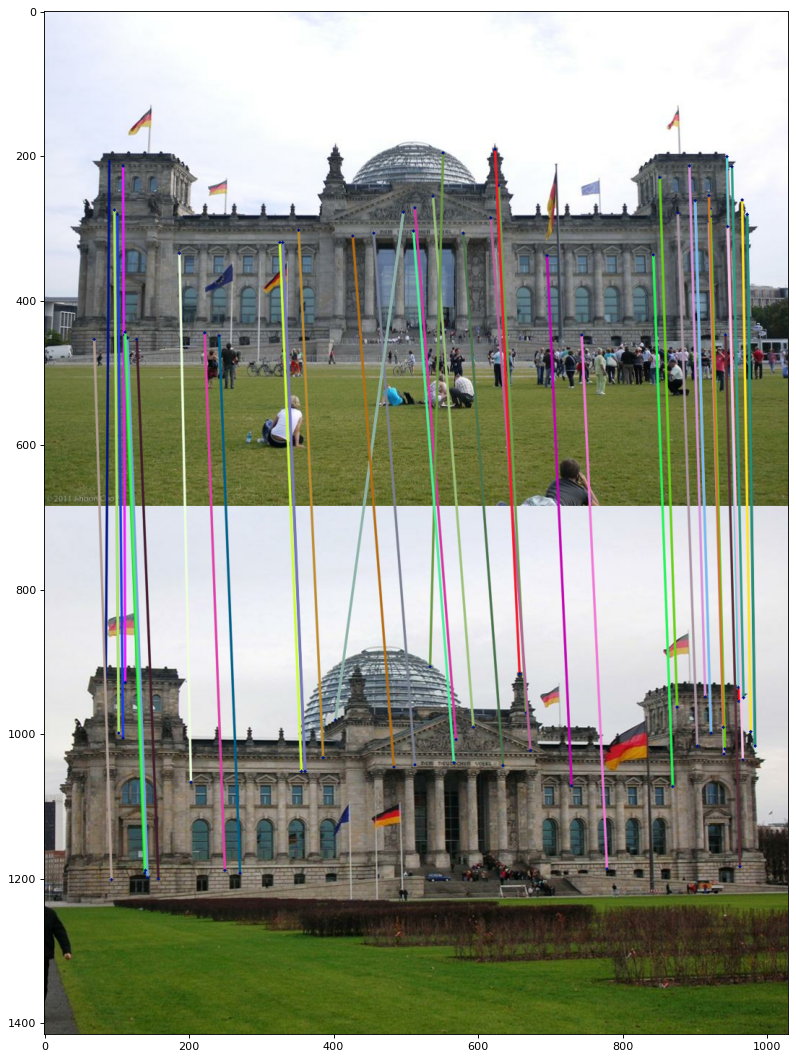

In [18]:
correspondence_image = viz.plot_twoview_correspondences(*images, keypoints_i1, keypoints_i2, v_corr_idxs)
fig = plt.figure(figsize=(12, 18), dpi=80)
fig.gca().imshow(correspondence_image.value_array)
plt.show()

In [19]:
# Create estimator
two_view_estimator = TwoViewEstimator(
    matcher=None, verifier=None, inlier_support_processor=None,
    bundle_adjust_2view=True, eval_threshold_px=4
)

In [20]:
i2Ri1_optimized, i2Ui1_optimized, corr_idxs = two_view_estimator.bundle_adjust(
    keypoints_i1, keypoints_i2, v_corr_idxs, camera_intrinsics_i1, camera_intrinsics_i2, i2Ri1, i2Ui1)
print(f"ypr={np.degrees(i2Ri1_optimized.xyz())}\nU={i2Ui1_optimized.point3().T}\nverified:{corr_idxs.shape}")

[2022-05-07 09:27:43,697 DEBUG two_view_estimator.py line 172 90173] Performed DA in 0.003371 seconds.
[2022-05-07 09:27:43,697 DEBUG two_view_estimator.py line 173 90173] Triangulation succeeded on 125 correspondences.
[2022-05-07 09:27:43,697 INFO bundle_adjustment.py line 193 90173] Input: 125 tracks on 2 cameras

[2022-05-07 09:27:44,400 INFO bundle_adjustment.py line 226 90173] [Result] Number of tracks after filtering: 125
[2022-05-07 09:27:44,401 DEBUG two_view_estimator.py line 188 90173] Performed 2-view BA in 0.703520 seconds.
ypr=[  1.27586227 -16.00271097   0.54841626]
U=[0.41065338 0.06390306 0.90954945]
verified:(125, 2)


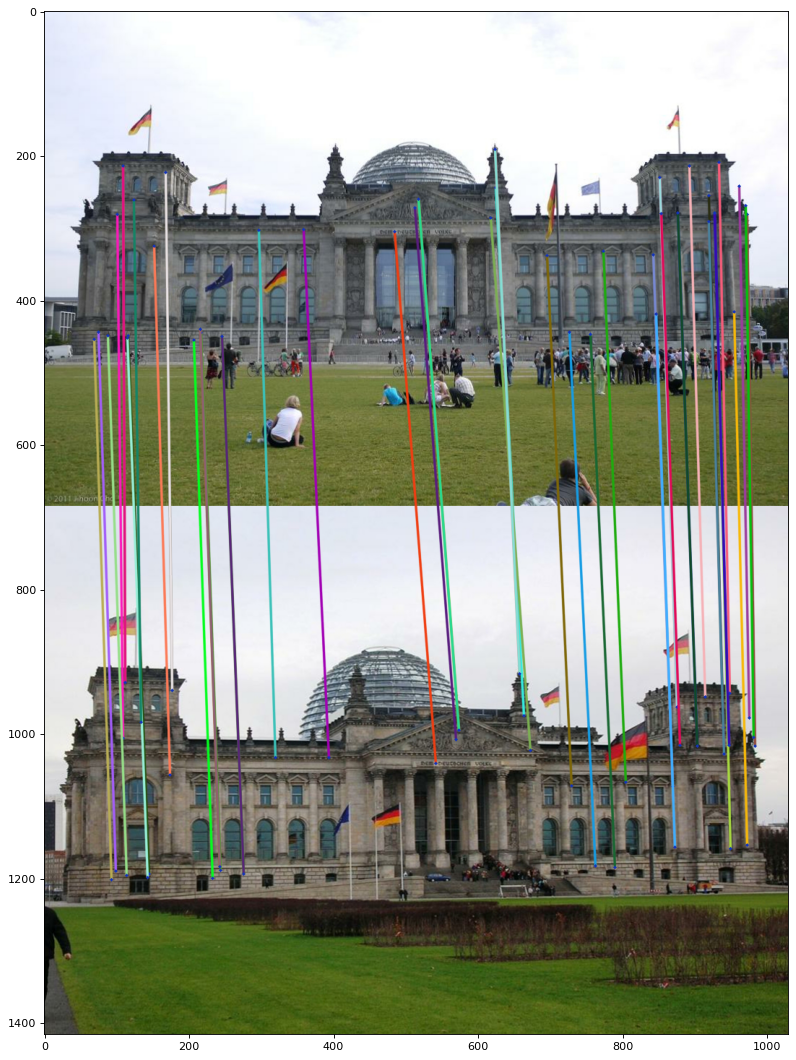

In [21]:
correspondence_image = viz.plot_twoview_correspondences(*images, keypoints_i1, keypoints_i2, corr_idxs)
fig = plt.figure(figsize=(12, 18), dpi=80)
fig.gca().imshow(correspondence_image.value_array)
plt.show()